# import libary

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import talib as ta
import matplotlib.pyplot as plt

# get data from yahoo finance and add detail

In [17]:
# Load gold historical data from Yahoo Finance
data = yf.download('^XAU', start='2020-01-01', end='2024-01-01') # โหลดข้อมูลมาแล้วระบุวันเริ่มกับวันสุดท้าย

data.head()

[*********************100%***********************]  1 of 1 completed

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^XAU,^XAU,^XAU,^XAU,^XAU,^XAU
Date,,,,,,
2020-01-02 00:00:00+00:00,106.510002,106.510002,108.349998,106.050003,107.860001,0
2020-01-03 00:00:00+00:00,105.410004,105.410004,108.029999,105.029999,107.449997,0
2020-01-06 00:00:00+00:00,105.070000,105.070000,107.120003,104.320000,106.459999,0
2020-01-07 00:00:00+00:00,106.209999,106.209999,106.610001,104.449997,104.900002,0
2020-01-08 00:00:00+00:00,101.870003,101.870003,106.290001,101.690002,106.260002,0


In [18]:
data['Return'] = data['Close'].pct_change() # ทำค่าผลต่างเป็นเปอร์เซ็นจากวันปัจจุบันและวันก่อนหน้า return ก็คือผลตอบแทนที่ดได้จากราคาปิดวันนี้เทียบกับเมื่อวาน
data.head()

Price,Adj Close,Close,High,Low,Open,Volume,Return
Ticker,^XAU,^XAU,^XAU,^XAU,^XAU,^XAU,
Date,,,,,,,
2020-01-02 00:00:00+00:00,106.510002,106.510002,108.349998,106.050003,107.860001,0,NaN
2020-01-03 00:00:00+00:00,105.410004,105.410004,108.029999,105.029999,107.449997,0,-0.010328
2020-01-06 00:00:00+00:00,105.070000,105.070000,107.120003,104.320000,106.459999,0,-0.003226
2020-01-07 00:00:00+00:00,106.209999,106.209999,106.610001,104.449997,104.900002,0,0.010850
2020-01-08 00:00:00+00:00,101.870003,101.870003,106.290001,101.690002,106.260002,0,-0.040862


In [19]:
# Add more technical indicators
# หา Simple Moving Average ช่วง 10 และ 50 วัน
data['SMA_10'] = ta.SMA(data['Close'].to_numpy().flatten(), timeperiod=10)
data['SMA_50'] = ta.SMA(data['Close'].to_numpy().flatten(), timeperiod=50)

# หา Relative Strength Index ในช่วง 14 วัน
# หาก RSI ต่ำกว่า 30% จะเรียกว่าภาวะ “ขายมากเกินไป” (Oversold)
# หาก RSI สูงกว่า 70% จะเรียกว่าภาวะ “ซื้อมากเกินไป” (Overbought)
data['RSI'] = ta.RSI(data['Close'].to_numpy().flatten(), timeperiod=14)

# หา Moving Average Convergence Divergence ตัว MACD หาได้จากความต่างของ EMA (Exponential Moving Average) สองเส้นหรือ EMA12 - EMA26
# เอาไว้ดูคู่กับ signal line เพื่อประกอบการตัดสินใจจังหวะซื้อหรือขาย
data['MACD'], data['MACD_Signal'], _ = ta.MACD(data['Close'].to_numpy().flatten(), fastperiod=12, slowperiod=26, signalperiod=9)

# Bollinger Bands กรอบราคาที่สามารเหวี่ยงไปได้ทั้งกรอบบน กรอบล่าง
data['BB_upper'], data['BB_middle'], data['BB_lower'] = ta.BBANDS(data['Close'].to_numpy().flatten(), timeperiod=20)

# หา momentum ซึ่งเป็นอัตราเร่งของราคา
data['Momentum'] = ta.MOM(data['Close'].to_numpy().flatten(), timeperiod=10)

# หาความผันผวนของราคาปิดเมื่อเทียบกับราคาสูงสุดและต่ำสุด
data['Volatility'] = ta.ATR(data['High'].to_numpy().flatten(), data['Low'].to_numpy().flatten(), data['Close'].to_numpy().flatten(), timeperiod=14)  # Added Volatility

# หาค่า Stochastic ออกมาเป็นเปอร์เซ็นเพื่อดูพฤติกรรมการซื้อขาย เพื่อหาจุดที่จะเก็งกำไร ส่วนใหญ่ทำในระยะสั้น
data['Stochastic'] = ta.STOCH(data['High'].to_numpy().flatten(), data['Low'].to_numpy().flatten(), data['Close'].to_numpy().flatten(), fastk_period=14, slowk_period=3)[0]  # Added Stochastic
data.head(20)

Price,Adj Close,Close,High,Low,Open,Volume,Return,SMA_10,SMA_50,RSI,MACD,MACD_Signal,BB_upper,BB_middle,BB_lower,Momentum,Volatility,Stochastic
Ticker,^XAU,^XAU,^XAU,^XAU,^XAU,^XAU,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,
2020-01-02 00:00:00+00:00,106.510002,106.510002,108.349998,106.050003,107.860001,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03 00:00:00+00:00,105.410004,105.410004,108.029999,105.029999,107.449997,0,-0.010328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06 00:00:00+00:00,105.070000,105.070000,107.120003,104.320000,106.459999,0,-0.003226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07 00:00:00+00:00,106.209999,106.209999,106.610001,104.449997,104.900002,0,0.010850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08 00:00:00+00:00,101.870003,101.870003,106.290001,101.690002,106.260002,0,-0.040862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09 00:00:00+00:00,100.690002,100.690002,102.050003,100.620003,100.980003,0,-0.011583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-10 00:00:00+00:00,102.250000,102.250000,102.900002,101.110001,101.120003,0,0.015493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-13 00:00:00+00:00,100.190002,100.190002,101.879997,100.190002,101.800003,0,-0.020147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Create lag features for capturing trends
# shift ข้อมูลลง 1 row
data['Return_Lag1'] = data['Return'].shift(1)
data['RSI_Lag1'] = data['RSI'].shift(1)
data['SMA_10_Lag1'] = data['SMA_10'].shift(1)
data['SMA_50_Lag1'] = data['SMA_50'].shift(1)

# Drop NaN values after adding new features
data.dropna(inplace=True)
data.head()

Price,Adj Close,Close,High,Low,Open,Volume,Return,SMA_10,SMA_50,RSI,...,BB_upper,BB_middle,BB_lower,Momentum,Volatility,Stochastic,Return_Lag1,RSI_Lag1,SMA_10_Lag1,SMA_50_Lag1
Ticker,^XAU,^XAU,^XAU,^XAU,^XAU,^XAU,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-16 00:00:00+00:00,75.180000,75.180000,78.669998,62.720001,68.190002,0,0.070026,91.252000,100.9560,29.037586,...,121.550908,98.1680,74.785093,-22.690002,6.170606,10.114004,-0.096683,21.869822,93.521000,101.5826
2020-03-17 00:00:00+00:00,85.000000,85.000000,86.550003,74.830002,74.830002,0,0.130620,89.605000,100.5478,40.726106,...,120.888939,97.1205,73.352061,-16.470001,6.566991,25.934539,0.070026,29.037586,91.252000,100.9560
2020-03-18 00:00:00+00:00,73.449997,73.449997,85.050003,71.790001,82.199997,0,-0.135882,86.682999,99.9154,33.695961,...,120.757222,95.4060,70.054778,-29.220001,7.045063,33.868996,0.130620,40.726106,89.605000,100.5478
2020-03-19 00:00:00+00:00,74.820000,74.820000,84.209999,66.309998,73.260002,0,0.018652,83.695000,99.2876,35.126445,...,119.929820,93.7520,67.574180,-29.879997,7.820416,34.322615,-0.135882,33.695961,86.682999,99.9154
2020-03-20 00:00:00+00:00,70.120003,70.120003,78.010002,70.019997,76.709999,0,-0.062817,80.406000,98.6526,32.533271,...,118.543374,91.7050,64.866626,-32.889999,7.832530,23.715382,0.018652,35.126445,83.695000,99.2876


# train model

In [8]:
# Define features and target
features = [
    'Return', 'SMA_10', 'SMA_50', 'RSI', 'MACD', 'MACD_Signal',
    'BB_upper', 'BB_middle', 'BB_lower', 'Momentum', 'Return_Lag1', 'RSI_Lag1',
    'SMA_10_Lag1', 'SMA_50_Lag1', 'Volatility', 'Stochastic'
]

# แปลง return เป็น 0, 1 สำหรับการทายวันจะขึ้นหรือลงเพื่อทำกำไรด้วยวิธีการ long short
data['Target'] = np.where(data['Return'].shift(-1) > 0, 1, 0)  # 1 for up, 0 for down

# แยก x y สำหรับการ train
X = data[features]
y = data['Target']

# Standardize the features
# สดกลตามค่า z (ภูเขา)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Use GridSearchCV to tune hyperparameters for better performance
# พาราเมเตอร์สำหรับการ train
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}
grid_search = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters from GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)

# Train the best model found by GridSearchCV
best_model = grid_search.best_estimator_

# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std():.2f})")

# Make predictions and evaluate on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.9}
Cross-Validation Accuracy: 0.50 (+/- 0.05)
Test Accuracy: 0.54


# back test

In [ ]:
# Backtesting with updated features and better portfolio simulation
capital = 10000  # Initial capital
capital_history = []

# Map test indices to the original DataFrame
test_indices = y_test.index.to_list() # คาดว่าวันไม่เรียงกัน

# Trade logic with stop-loss and take-profit to reduce risk
for i in range(len(test_indices) - 1):
    current_idx = test_indices[i]
    next_idx = test_indices[i + 1]

    prediction = best_model.predict([X_test[i]])[0]
    price_today = data['Close'].loc[current_idx]["^XAU"]
    price_next_day = data['Close'].loc[next_idx]["^XAU"]

    # Set stop-loss and take-profit levels
    stop_loss_pct = 0.02  # 2% stop loss ไม่ขาดทุนกว่านี้
    take_profit_pct = 0.05  # 5% take profit กำไรแค่นี้พอแล้ว
    # Long position logic (buy if predicted up)
    if prediction == 1:
        profit = (price_next_day - price_today) / price_today * capital
        if profit < -stop_loss_pct * capital:
            profit = -stop_loss_pct * capital  # Stop loss triggered
        elif profit > take_profit_pct * capital:
            profit = take_profit_pct * capital  # Take profit triggered
    else:  # Short position logic (sell if predicted down)
        profit = (price_today - price_next_day) / price_today * capital
        if profit < -stop_loss_pct * capital:
            profit = -stop_loss_pct * capital  # Stop loss triggered
        elif profit > take_profit_pct * capital:
            profit = take_profit_pct * capital  # Take profit triggered

    capital += profit
    capital_history.append(capital)

[Timestamp('2021-07-23 00:00:00+0000', tz='UTC'),
 Timestamp('2023-08-21 00:00:00+0000', tz='UTC'),
 Timestamp('2022-04-08 00:00:00+0000', tz='UTC'),
 Timestamp('2022-05-11 00:00:00+0000', tz='UTC'),
 Timestamp('2022-11-28 00:00:00+0000', tz='UTC'),
 Timestamp('2020-09-28 00:00:00+0000', tz='UTC'),
 Timestamp('2021-01-19 00:00:00+0000', tz='UTC'),
 Timestamp('2020-11-11 00:00:00+0000', tz='UTC'),
 Timestamp('2020-07-17 00:00:00+0000', tz='UTC'),
 Timestamp('2021-04-27 00:00:00+0000', tz='UTC'),
 Timestamp('2022-06-27 00:00:00+0000', tz='UTC'),
 Timestamp('2020-06-19 00:00:00+0000', tz='UTC'),
 Timestamp('2023-02-07 00:00:00+0000', tz='UTC'),
 Timestamp('2023-12-22 00:00:00+0000', tz='UTC'),
 Timestamp('2022-07-06 00:00:00+0000', tz='UTC'),
 Timestamp('2021-04-19 00:00:00+0000', tz='UTC'),
 Timestamp('2020-04-28 00:00:00+0000', tz='UTC'),
 Timestamp('2023-09-29 00:00:00+0000', tz='UTC'),
 Timestamp('2023-07-10 00:00:00+0000', tz='UTC'),
 Timestamp('2022-10-24 00:00:00+0000', tz='UTC'),


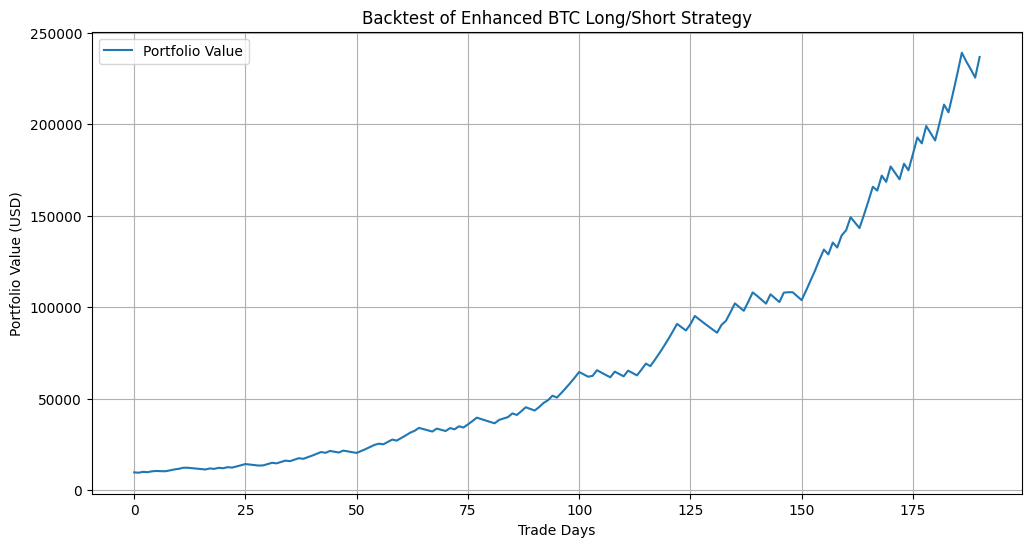

In [11]:
# Plot backtest results
plt.figure(figsize=(12, 6))
plt.plot(capital_history, label='Portfolio Value')
plt.title('Backtest of Enhanced BTC Long/Short Strategy')
plt.xlabel('Trade Days')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.grid(True)
plt.show()